# Predicting Loan Repayment with Automated Feature Engineering in Featuretools
# 通过Featuretools自动特征工程预测贷款偿还

Feature engineering is the process of creating new features (also called predictors or explanatory variables) out of an existing dataset. Traditionally, this process is done by hand using domain knowledge to build new features one at a time. In a previous notebook, we saw that feature engineering is crucial for a data science problem and how the manual approach is time-consuming, tedious, error-prone, and must be re-done for each problem. Automated feature engineering aims to aid the data scientist in this critical process by automatically creating hundreds or thousands of new features from a set of related tables in a fraction of the time as the manual approach. In this notebook, we will apply automated feature engineering to the Home Credit Default Risk loan dataset using [Featuretools, an open-source Python library](https://www.featuretools.com/) for automated feature engineering.  
特征工程是一个基于现有数据构建新特征(也称作预测变量或具有解释的变量)的过程. 传统上,使用领域知识手工一次构建一个来完成特征工程.在以前的笔记中,我们知道特征工程对于数据科学至关重要但人工方法很耗时,乏味,容易出错以及必须针对每个项目重做.自动化特征工程是在短时间内从一组关系表中自动构建成百上千新特征从而如同人工方法一样在这一关键过程中为数据科学家提供帮助.在本文,我们使用[Featuretools,一个Python开源库]将自动化特征工程应用于房贷信用贷违约风险数据集以进行自动构建特征.

This problem is a machine learning competition currently running on Kaggle where the objective is to predict if an applicant will default on a loan given comprehensive data on past loans and applicants. The data is spread across seven different tables making this an ideal problem for automated feature engineering: all of the data must be gathered into a single dataframe for training (and one for testing) with the aim of capturing as much usable information for the prediction problem as possible. As we will see, featuretools can efficiently carry out the tedious process of using all of these tables to make new features with only a few lines of code. Moreover, this code is generally applicable to any data science problem!  
这个课题是目前在Kaggle上进行的机器学习竞赛项目,意图是给定历史贷款和申请数据的情况下,预测申请人是否会拖欠贷款. 数据分布在7个不同的表中, 这成为自动化特征工程中一个目标:必须将所有数据整合到一个DataFrame数据框用作训练(一个用于测试), 旨在为预测问题捕获尽可能多的可用信息. 正如所见,Featuretools只需要几行代码有效地执行这些繁琐的过程,即基于这些表构建新特征.而且,此代码通用与任何数据科学问题.

In this notebook, we will implement an automated feature engineering approach to the loan repayment problem. While Featuretools allows plenty of options for customization of the library to improve accuracy, we'll focus on a fairly high-level implementation. (Later notebooks, including Engine Life and Retail Spending show some of the additional features of the library).  
在本文中,我们将实现一个自动特征工程方法来解决贷款偿还问题.而Featuretools提供了许多用于自定义的选项以提高准确性,我们将更专注于比较高级的实现.(后文,包括"Engine Life"和"Retail Spending"展示该库的一些额外功能).

Our approach will be as follows with the background covered as we go:  
本文方法将包括以下内容:

* 1. Read in the set of related data tables
* 1. 读取关系数据表集合
* 2. Create a featuretools `EntitySet` and add `entities` to it
* 2. 创建一个Featuretools的`实体集`且为它添加`实体`
    * Identify correct variable types as required
    * 根据需要识别正确的变量类型
    * Identify indices in data
    * 识别数据索引
* 3. Add relationships between `entities`
* 3. 为`实体`之间添加关联关系
* 4. Select feature primitives to use to create new features
* 4. 选择特征基元用于创建新特征
    * Use basic set of primitives
    * 基本基元集
    * Examine features that will be created
    * 检查将要被创建的特征
* 5. Run Deep Feature Synthesis to generate thousands of new features
* 5. 运行深度特征合成生成成千上万个新特征


## Problem and Dataset
## 课题中的数据集

The [Home Credit Default Risk competition](https://www.kaggle.com/c/home-credit-default-risk) currently running on Kaggle is a supervised classification task where the objective is to predict whether or not an applicant for a loan (known as a client) will default on the loan. The data comprises socio-economic indicators for the clients, loan specific financial information, and comprehensive data on previous loans at Home Credit (the institution sponsoring the competition) and other credit agencies. The metric for this competition is Receiver Operating Characteristic Area Under the Curve (ROC AUC) with predictions made in terms of the probability of default. We can evaluate our submissions both through cross-validation on the training data (for which we have the labels) or by submitting our test predictions to Kaggle to see where we place on the public leaderboard (which is calculated with only 10% of the testing data).  
目前在Kaggle上运行的[房屋贷款信用违约风险竞赛](https://www.kaggle.com/c/home-credit-default-risk)是一项监督分类任务，目的是预测申请人(或称之为客户)申请贷款将是否拖欠该贷款. 该数据包括客户的社会经济指标,历史贷款的特定财务信息,以及有关 Home Credit（赞助比赛的机构）和其他信贷机构历史贷款的综合数据. 此项竞赛的度量标准是受试者特征曲线（ROC AUC），并根据违约情况进行了预测。我们可以通过交叉验证训练数据(带有标签)或将测试预测提交给Kaggle以查看我们在公共排行榜上的位置(仅通过10％的测试计算得出)来评估提交的内容数据.

The Home Credit Default Risk dataset ([available for download here](https://www.kaggle.com/c/home-credit-default-risk/data)) consists of seven related tables of data:  
房屋贷款信用风险数据集是由7个表构成:

* application_train/application_test: the main training/testing data for each client at Home Credit. The information includes both socioeconomic indicators for the client and loan-specific characteristics. Each loan has its own row and is uniquely identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid.
* application_train/application_test:trainning/testing为每个客户的主要家庭授信数据, 主要包括客户社会经济指标和特定的贷款特征.每笔贷款都有唯一的行并由特征`SK_ID_CURR`作为唯一标识符.application_train数据带有`TARGET`列, 其中,0:标识贷款已被偿还, 1标识贷款未被偿还.  

* bureau: data concerning client's previous credits from other financial institutions (not Home Credit). Each previous credit has its own row in bureau, but one client in the application data can have multiple previous credits. The previous credits are uniquely identified by the feature `SK_ID_BUREAU`.
* bureau: 历史信用数据, 有关客户历史从其他金融机构获得的信用数据(而非家庭信贷)的数据。每笔贷款历史信用在表中都有其自己的行，但是申请表中的一个客户可以具有多笔历史借贷数据。历史信用表由特征`SK_ID_BUREAU`作为唯一标识. 

* bureau_balance: monthly balance data about the credits in bureau. Each row has information for one month about a previous credit and a single previous credit can have multiple rows. This is linked backed to the bureau loan data by `SK_ID_BUREAU` (not unique in this dataframe).
* bureau_balance: 贷款账户月度余额,有关征信局的贷款账户月度余额数据.每行都有一个贷款账户信息,单个贷款账户可以有很多行. 这是征信局中回溯每笔贷款历史还款行为数据, 通过`SK_ID_BUREAU`标识每笔贷款(没有唯一索引).

* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each client in the application data can have multiple previous loans. Each previous application has one row in this dataframe and is uniquely identified by the feature `SK_ID_PREV`. 
* previous_application:在申请表中的客户历史上在Home Credit申请贷款笔数,申请数据表中的每个客户可以拥有多笔历史贷款. 每笔历史贷款在这张表中都有且仅有一行,并由特征`SK_ID_PREV`作为唯一标识.

* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans from the previous loan data. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).
* POS_CASH_BALANCE: 月度余额, 有关历史销售点的月度数据或来自历史贷款数据的现金贷款. 每行是销售点或现金贷款的一个月的数据, 并且一笔历史的贷款可以有多行.这是征信局中回溯每笔现金贷款或销售点历史还款行为数据, 通过`SK_ID_PREV`标识每笔贷款(没有唯一索引).

* credit_card_balance: monthly data about previous credit cards loans from the previous loan data. Each row is one month of a credit card balance, and a single credit card can have many rows. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).
* credit_card_balance: 信用卡贷款月度余额数据, 每一行记录一张信用卡一个月的余额, 且单张信用卡可以有很多行. 这些记录是回溯信用卡历史贷款每个月还款数据,并通过`SK_ID_PREV`标识每张卡(没有唯一索引). 

* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).
* installments_payment: 分期付款, 以前在Home Credit上的贷款付款历史记录. 每笔付款和每笔未支付的款项都有一行. 通过`SK_ID_PREV`关联历史贷款(在此表中不是唯一的). 

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

### Read in Data

First we can read in the seven data tables. We also replace the anomalous values previously identified (we did the same process with manual feature engineering).  
首先我们需要读取这7张表,并进行异常值处理(这在手工特征工程也一样).

In [2]:
# Read in the datasets and replace the anomalous values
# 读取数据集并替换异常值
app_train = pd.read_csv('input/application_train.csv').replace({365243: np.nan})
app_test = pd.read_csv('input/application_test.csv').replace({365243: np.nan})
bureau = pd.read_csv('input/bureau.csv').replace({365243: np.nan})
bureau_balance = pd.read_csv('input/bureau_balance.csv').replace({365243: np.nan})
cash = pd.read_csv('input/POS_CASH_balance.csv').replace({365243: np.nan})
credit = pd.read_csv('input/credit_card_balance.csv').replace({365243: np.nan})
previous = pd.read_csv('input/previous_application.csv').replace({365243: np.nan})
installments = pd.read_csv('input/installments_payments.csv').replace({365243: np.nan})

We will join together the training and testing datasets to make sure we build the same features for each set. Later, after the feature matrix is built, we can separate out the two sets.  
我们将traing和testing数据集合并以确保生成相同的特征, 特征矩阵被构建后,再把两个数据集拆分.

In [5]:
app_test['TARGET'] = np.nan

# Join together training and testing
app = app_train.append(app_test, ignore_index = True, sort = True)

Several of the indexes are an incorrect data type (floats) so we need to make these all the same (integers) for adding relationships.  
几个索引是错误的数据类型(浮点数),因此我们需要使它们全部相同(整数)以添加关系,且以 0 填充缺失值

In [6]:
for index in ['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU']:
    for dataset in [app, bureau, bureau_balance, cash, credit, previous, installments]:
        if index in list(dataset.columns):
            dataset[index] = dataset[index].fillna(0).astype(np.int64)

# Featuretools Basics
# Featuretools 基础

[Featuretools](https://docs.featuretools.com/#minute-quick-start) is an open-source Python library for automatically creating features out of a set of related tables using a technique called [Deep Feature Synthesis](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf). Automated feature engineering, like many topics in machine learning, is a complex subject built upon a foundation of simpler ideas. By going through these ideas one at a time, we can build up our understanding of Featuretools which will later allow for us to get the most out of it.  
Featuretools是一个使用一种技术叫做`Deep Feature Synthesis` 深度特征合成从一组相关表中创建特征的python开源库.自动特征工程,像许多机器学习主题一样, 是一个基于简单思想的复杂主题.通过这一次研究这些思想,我们建立对Featuretools的理解,以后更加充分利用它. 

There are a few concepts that we will cover along the way:  
在此过程中我们会涉及一些概念:

* [Entities and EntitySets](https://docs.featuretools.com/loading_data/using_entitysets.html): our tables and a data structure for keeping track of them all
* [实体 and 实体集合]: 表和用于追踪所有表格的数据结构
* [Relationships between tables](https://docs.featuretools.com/loading_data/using_entitysets.html#adding-a-relationship): how the tables can be related to one another
* [表之间关系]:一张表与另一张表如何关联 
* [Feature primitives](https://docs.featuretools.com/automated_feature_engineering/primitives.html): aggregations and transformations that are stacked to build features
* [特征基元]:聚合和转换通过堆叠以构建特征,通俗理解就是业务主键,通常是业务订单号. 
* [Deep feature synthesis](https://docs.featuretools.com/automated_feature_engineering/afe.html): the method that uses feature primitives to generate thousands of new features
* [深度特征合成]: 使用特征基元生成成千上万个新特征的方法

# Entities and Entitysets
# 实体和实体集合
An entity is simply a table or in Pandas, a `dataframe`. The observations must be in the rows and the features in the columns. An entity in featuretools must have a unique index where none of the elements are duplicated.  Currently, only `app`, `bureau`, and `previous` have unique indices (`SK_ID_CURR`, `SK_ID_BUREAU`, and `SK_ID_PREV` respectively). For the other dataframes, when we create entities from them, we must pass in `make_index = True` and then specify the name of the index.  
实体是简单的一张表或pandas的`dataframe`数据框. 观测值必须在行中,特征必须在列中. 一个实体在Featuretools中必须有一个唯一的缩影且索引不重复. 目前, 只有`app`, `bureau`和`previous`具有唯一索引(分别是`SK_ID_CURR`, `SK_ID_BUREAU`, 和 `SK_ID_PREV`). 对于别的数据框, 我们必须通过制定参数`make_index=True`参数为这些没有唯一索引的数据框创建索引并命名.

Entities can also have time indices that represent when the information in the row became known. (There are not datetimes in any of the data, but there are relative times, given in months or days, that could be treated as time variables, although we will not use them as time in this notebook).
实体也可以具有时间索引,一个时间索引可以指定该行信息(任何数据中都没有日期时间, 但是有一些相对时间（以月或天为单位）可以视为时间变量, 尽管在本文中我们不会将其用作时间索引). 

An [EntitySet](https://docs.featuretools.com/loading_data/using_entitysets.html) is a collection of tables and the relationships between them. This can be thought of a data structure with its own methods and attributes. Using an EntitySet allows us to group together multiple tables and will make creating the features much simpler than keeping track of individual tables and relationships. __EntitySets and entities are abstractions that can be applied to any dataset because they do not depend on the underlying data.__  
一个实体集由表及其之间的关系构成. 这来自数据结构自身的方法和属性.使用实体集可使我们将多个表组合在一起使创建特征, 这比跟踪单个表和关系简单得多.实体集和实体是可以应用于任何数据集的抽象,因为它们不依赖于基础数据特定字段. 

First we'll make an empty entityset named clients to keep track of all the data.  
首先我们初始化一个空实体集命名为`clients`.

In [7]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

### Variable Types  
### 变量类型

Featuretools will automatically infer the variable types. However, there may be some cases where we need to explicitly tell featuretools the variable type such as when a boolean variable is represented as an integer. Variable types in featuretools can be specified as a dictionary.  
Featuretools 会自动推断变量类型. 然而,有些特征我们需要向Featuretools指定变量类型, 例如表现为整数的bool变量. 在Featuretools中可以通过一个字典指定变量类型.

We will first work with the `app` data to specify the proper variable types. To identify the `Boolean` variables that are recorded as numbers (1.0 or 0.0), we can iterate through the data and find any columns where there are only 2 unique values and the data type is numeric. We can also use the column definitions to find any other data types that should be identified, such as `Ordinal` variables. Identifying the correct variable types is important because Featuretools applies different operations to different data types (just as we do when manual feature engineering).  
我们首先要为`app`数据指定正确的变量类型,即辨别已经记录为数值(1.0或0.0)的`Boolean`变量,我们可以遍历数据集中的每个变量是否只有2值且类型为数值.我们也可以直接指定某个列为特定类型, 例如有序变量`Ordinal`类型.识别正确的变量类型很重要,因为Featuretools是根据不同的数据类型运行不同的操作逻辑(如同我们进行人工构建特征工程一样).    

In [8]:
import featuretools.variable_types as vtypes

In [9]:
app_types = {}

# Handle the Boolean variables:
# 手动指定`Boolean`变量

for col in app.columns:
    if (app[col].nunique() == 2) and (app[col].dtype == float):
        app_types[col] = vtypes.Boolean

# Remove the `TARGET`
del app_types['TARGET']

print('There are {} Boolean variables in the application data.'.format(len(app_types)))

There are 32 Boolean variables in the application data.


In [10]:
# Ordinal variables
# 有序离散变量
app_types['REGION_RATING_CLIENT'] = vtypes.Ordinal
app_types['REGION_RATING_CLIENT_W_CITY'] = vtypes.Ordinal
app_types['HOUR_APPR_PROCESS_START'] = vtypes.Ordinal

The `previous` table is the only other `entity` that has features which should be recorded as Boolean. Correctly identifying the type of column will prevent featuretools from making irrelevant features such as the mean or max of a `Boolean`.  
`previous`数据表是唯一应记录为`Boolean`特征的其他实体.正确地指定变量类型避免Featuretools构建无意义的特征,例如对`Boolean`进行求均值或求最大值.

In [11]:
previous_types = {}

# Handle the Boolean variables:
for col in previous:
    if (previous[col].nunique() == 2) and (previous[col].dtype == float):
        previous_types[col] = vtypes.Boolean

print('There are {} Boolean variables in the previous data.'.format(len(previous_types)))

There are 2 Boolean variables in the previous data.


In addition to identifying Boolean variables, we want to make sure featuretools does not create nonsense features such as statistical aggregations (mean, max, etc.) of ids. The `credit`, `cash`, and `installments` data all have the `SK_ID_CURR` variable. However, we do not actually need this variable in these dataframes because we link them to `app` through the `previous` dataframe with the `SK_ID_PREV` variable.  
除了标记为`Boolean`变量外, 我们必须确保Featuretools不会构造没有意义的特征, 例如统计聚合(均值,最大值等).`credit`, `cash`, and `installments`表数据都有`SK_ID_CURR` 变量. 然而,实际上我们不需要这个变量,因为是通过表`previous`中的 `SK_ID_PREV`关联到表`app`中. 

We don't want to make features from `SK_ID_CURR` since it is an arbitrary id and should have no predictive power. 
Our options to handle these variables is either to tell featuretools to ignore them, or to drop the features before including them in the entityset. We will take the latter approach.  
我们并不基于`SK_ID_CURR`创建特征, 因为他是没有业务意义的id,并不具有预测能力. 我们处理这些变量的选项是告诉Featuretools忽略它们. 活着在将数据表加入实体集之前就将它们移除, 我们将采用后一种方法.

In [12]:
installments = installments.drop(columns = ['SK_ID_CURR'])
credit = credit.drop(columns = ['SK_ID_CURR'])
cash = cash.drop(columns = ['SK_ID_CURR'])

## Adding Entities
## 添加实体集

Now we define each entity, or table of data, and add it to the `EntitySet`. We need to pass in an index if the table has one or `make_index = True` if not. In the cases where we need to make an index, we must supply a name for the index. We also need to pass in the dictionary of variable types if there are any specific variables we should identify. The following code adds all seven tables to the `EntitySet`.<br>现在我们定义了每个实体,表数据, 并将其添加到实体集. 如果没有表索引则需要创建索引或设置参数`make_index=True`. 在这个案例中我们需要创建一个索引,并为这个索引命名. 与此同时,我们通过变量类型字典指定个别需特定的变量类型. 以下代码将7张表添加到实体集中.

In [13]:
# Entities with a unique index
# 具有唯一索引的实体
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR',
                              variable_types = app_types)

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV',
                              variable_types = previous_types)

# Entities that do not have a unique index
# 没有唯一索引的实体, 通过`make_index=True`参数标记,并通过`index`参数命名
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

In [14]:
# Display entityset so far
# 显示到目前为止的添加的实体
es

Entityset: clients
  Entities:
    app [Rows: 356255, Columns: 122]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 8]
    installments [Rows: 13605401, Columns: 8]
    credit [Rows: 3840312, Columns: 23]
  Relationships:
    No relationships

The `EntitySet` allows us to group together all of our tables as one data structure. This is much easier than manipulating the tables one at a time (as we have to do in manual feature engineering).<br> `实体集`允许我们将所有分表组成一个数据结构. 这相对于一次操作一张表容易得多(正如我们人工构建特征工程那样).

# Relationships
# 实体间关系
Relationships are a fundamental concept not only in featuretools, but in any relational database. The most common type of relationship is one-to-many. The best way to think of a one-to-many relationship is with the analogy of parent-to-child. A parent is a single individual, but can have mutliple children. In the context of tables, a parent table will have one row (observation) for every individual while a child table can have many observations for each parent.  In a _parent table_, each individual has a single row and is uniquely identified by an index (also called a key). Each individual in the parent table can have multiple rows in the _child table_. Things get a little more complicated because children tables can have children of their own, making these grandchildren of the original parent. <br>实体间关系不仅是Featuretools中的一个基本概念,也是任何关系型数据库表间关系.表间关系最常见得类型之一就是一对多关系.一对多关系最好的思路之一是将其比喻为父子关系.父是一个单一的个体,但是可以有多个子.在表前后关系中, 一个父表对应每个个体都有唯一一个观测行, 而每个子表对应父表每个个体可以有很多个观测行.在一个父表中, 每个个体有一个单独的行且是通过索引确定的唯一行(也可以叫做主键). 每一个父表中的个体在子表中可以有多行.还可以更复杂,因为子表也可以有他们自己的子表.作为父表的孙子表.     

As an example of a parent-to-child relationship, the `app` dataframe has one row for each client (identified by `SK_ID_CURR`) while the `bureau` dataframe has multiple previous loans for each client. Therefore, the `bureau` dataframe is the child of the `app` dataframe. The `bureau` dataframe in turn is the parent of `bureau_balance` because each loan has one row in `bureau` (identified by `SK_ID_BUREAU`) but multiple monthly records in `bureau_balance`. When we do manual feature engineering, keeping track of all these relationships is a massive time investment (and a potential source of error), but we can add these relationships to our `EntitySet` and let featuretools worry about keeping the tables straight!
<br>作为父与子关系案例, 每个客户在数据框`app`都有一行(通过`SK_ID_CURR`标记),与此同时每个客户在表`bureau`中有多笔历史贷款.因此, 表`bureau`是表`app`的子表. 表`bureau`是表`bureau_balance`父表因为表`bureau`中的每一笔贷款(通过`SK_ID_BUREAU`指定)在表`bureau_balance`中有多个月还款记录.当我们进行人工特征工程时,跟踪这些关系需要投入大量的时间(也是常见错误的来源). 我们可以将这些关系添加到`实体集`中并让Featuretools跟踪执行.  

In [15]:
print('Parent: app, Parent Variable of bureau: SK_ID_CURR\n\n', app.iloc[:, 111:115].head())
print('\nChild: bureau, Child Variable of app: SK_ID_CURR\n\n', bureau.iloc[:, :5].head())

Parent: app, Parent Variable of bureau: SK_ID_CURR

    SK_ID_CURR  TARGET  TOTALAREA_MODE WALLSMATERIAL_MODE
0      100002     1.0          0.0149       Stone, brick
1      100003     0.0          0.0714              Block
2      100004     0.0             NaN                NaN
3      100006     0.0             NaN                NaN
4      100007     0.0             NaN                NaN

Child: bureau, Child Variable of app: SK_ID_CURR

    SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT
0      215354       5714462        Closed      currency 1       -497.0
1      215354       5714463        Active      currency 1       -208.0
2      215354       5714464        Active      currency 1       -203.0
3      215354       5714465        Active      currency 1       -203.0
4      215354       5714466        Active      currency 1       -629.0


The `SK_ID_CURR` 215354 has one row in the parent table and multiple rows in the child. 
`SK_ID_CURR`215354行在父表中每一个只有一行但是在子表中有多行.
Two tables are linked via a shared variable. The `app` and `bureau` dataframe are linked by the `SK_ID_CURR` variable while the `bureau` and `bureau_balance` dataframes are linked with the `SK_ID_BUREAU`. The linking variable is called the `parent` variable in the parent table and the `child` variable in the child table.
<br>两张表通过一个共享变量链接. 表`app`和表`bureau`通过`Sk_ID_CURR`变量链接, 而表`bureau`和表`bureau_balance`通过`SK_ID_BUREAU`链接. 这个链接变量在父表中称为`父`变量, 在子表中称为`子`变量.

In [16]:
print('Parent: bureau, Parent Variable of bureau_balance: SK_ID_BUREAU\n\n', bureau.iloc[:, :5].head())
print('\nChild: bureau_balance, Child Variable of bureau: SK_ID_BUREAU\n\n', bureau_balance.head())

Parent: bureau, Parent Variable of bureau_balance: SK_ID_BUREAU

    SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT
0      215354       5714462        Closed      currency 1       -497.0
1      215354       5714463        Active      currency 1       -208.0
2      215354       5714464        Active      currency 1       -203.0
3      215354       5714465        Active      currency 1       -203.0
4      215354       5714466        Active      currency 1       -629.0

Child: bureau_balance, Child Variable of bureau: SK_ID_BUREAU

    bureaubalance_index  SK_ID_BUREAU  MONTHS_BALANCE STATUS
0                    0       5715448               0      C
1                    1       5715448              -1      C
2                    2       5715448              -2      C
3                    3       5715448              -3      C
4                    4       5715448              -4      C


Traditionally, we use the relationships between parents and children to aggregate data by grouping together all the children for a single parent and calculating statistics. For example, we might group together all the loans for a single client and calculate the average loan amount. This is straightforward, but can grow extremely tedious when we want to make hundreds of these features. Doing so one at a time is extremely inefficient especially because we end up re-writing much of the code over and over again and this code cannot be used for any different problem! <br> 常规上,我们利用父与子之间关系通过将一个父的所有子分组聚合数据从而进行统计计算. 例如,我们可以将一个客户的所有贷款汇总并计算平均贷款金额.这是很直接的,但是当我们想要构建这些成百上千的特征就会变得非常乏味.一次构建一个这样的特征非常低效,因为我们需要一遍又一遍重复写这些代码且这些代码并不能应用于不同的项目!    

Things get even worse when we have to aggregate the grandchildren because we have to use two steps: first aggregate at the parent level, and then at the grandparent level. Soon we will see that featuretools can do this work automatically for us, generating thousands of features from __all__ of the data tables. When we did this manually it took about 15 minutes per feature (as we saw in the manual feature engineering notebook) so featuretools potentially saves us hundreds of hours.
<br>当我们需要聚合祖孙表时事情将变得更糟糕, 因为我们需要两步: 首先聚合父级, 然后再聚合祖父级.待会我们将见到Featuretools可以自动完成这些工作, 并给予这些数据生成成千上万的特征. 当我们人工构建这些特征平均每个花费15分钟(正如我们人工构建特征一样),如果完成Featuretools构建这些特征将耗费数小时. 


### Adding Relationships
### 添加关系
Defining the relationships is straightforward using the diagram for the data tables. For each relationship, we need to first specify the parent variable and then the child variable. Altogether, there are a total of 6 relationships between the tables (counting the training and testing relationships as one). Below we specify these relationships and then add them to the EntitySet.
<br>直接使用图数据表定义关系, 对于每个关系,首先需要指定父变量和子变量,在这些表之间总共有6个关系(将trainning和testing关系当做一个).以下我们指明实体与实体之间的关系并将其添加到实体集中.   

In [17]:
# Relationship between app_train and bureau
# app_train 与 bureau 关联
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
# bureau 与 balance 关联
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
# app 和 previous apps 关联
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
# previous apps and cash, installments, and credit实体之间的关系

r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [18]:
# Add in the defined relationships
# 添加定义的实体关系
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app [Rows: 356255, Columns: 122]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 8]
    installments [Rows: 13605401, Columns: 8]
    credit [Rows: 3840312, Columns: 23]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

Again, we can see the benefits of using an `EntitySet` that is able to track all of the relationships for us. This allows us to work at a higher level of abstraction, thinking about the entire dataset rather than each individual table, greatly increasing our efficiency.
<br> 再次,使用实体集的好处是实体集能为我们追踪实体关系.这使得我们可以在更高的抽象水平上工作, 考虑整个数据集,而不是每个个体数据表, 极大地提升效率.

__Slightly advanced note__: we need to be careful to not create a [diamond graph](https://en.wikipedia.org/wiki/Diamond_graph) where there are multiple paths from a parent to a child. If we directly link `app` and `cash` via `SK_ID_CURR`; `previous` and `cash` via `SK_ID_PREV`; and `app` and `previous` via `SK_ID_CURR`, then we have created two paths from `app` to `cash`. This results in ambiguity, so the approach we have to take instead is to link `app` to `cash` through `previous`. We establish a relationship between `previous` (the parent) and `cash` (the child) using `SK_ID_PREV`. Then we establish a relationship between `app` (the parent) and `previous` (now the child) using `SK_ID_CURR`. Then featuretools will be able to create features on `app` derived from both `previous` and `cash` by stacking multiple primitives.
<br>粗略概要:我们需要谨慎地在多个来自父表的子表创建菱形图链路. 如果我们直接通过`SK_ID_CURR`链接表`app`和表`cash`;通过`SK_ID_PREV`链接`previous` and `cash`; 通过`SK_ID_CURR`链接`app` 和 `previous`, 然后通过`app`和`cash`创建链路.这个链路显得模糊不清, 因此我们可以通过`previous`替代`app`和`cash`的链接,使用`SK_ID_PREV`在`previous`(父)与`cash`(子)之间创建关系. 然后使用`SK_ID_CURR`在`app`(父)和`previous`(子)之间创建一个关系.然后Featuretools可以通过多重基元堆叠在`app`上创建特征衍生自`previous`和`cash`.

If this doesn't make too much sense, then just remember to only include one path from a parent to any descendents. For example, link a grandparent to a grandchild through the parent instead of directly through a shared variable.
<br> 如果这不好理解, 那么只要记住一个路径包括一个父到任何后代. 例如, 一个祖父到祖孙的链路是通过父而不是直接通过共享变量.

All entities in the entity can be linked through these relationships. In theory this allows us to calculate features for any of the entities, but in practice, we will only calculate features for the `app` dataframe since that will be used for training/testing. The end outcome will be a dataframe that has one row for each client in `app` with thousands of features for each individual. 
<br> 所有实体都可以通过链路进行关联.理论上这使得我们可以计算任何实体特征, 但是在实践中, 我们只以表`app`为基准计算特征因为他是用于训练/预测. 最终结果是一个dataframe数据框,且每一个在`app`中客户将有成千上万个特征.

We are almost to the point where we can start creating thousands of features but we still have a few foundational topics to understand. The next building block to cover is feature primitives.
我们几乎可以开始构建成千上万个特征了, 但是还有一些基础概念需要了解. 以下将介绍特征基元.

## Visualize EntitySet
## 可视化特征实体

In [19]:
%matplotlib inline

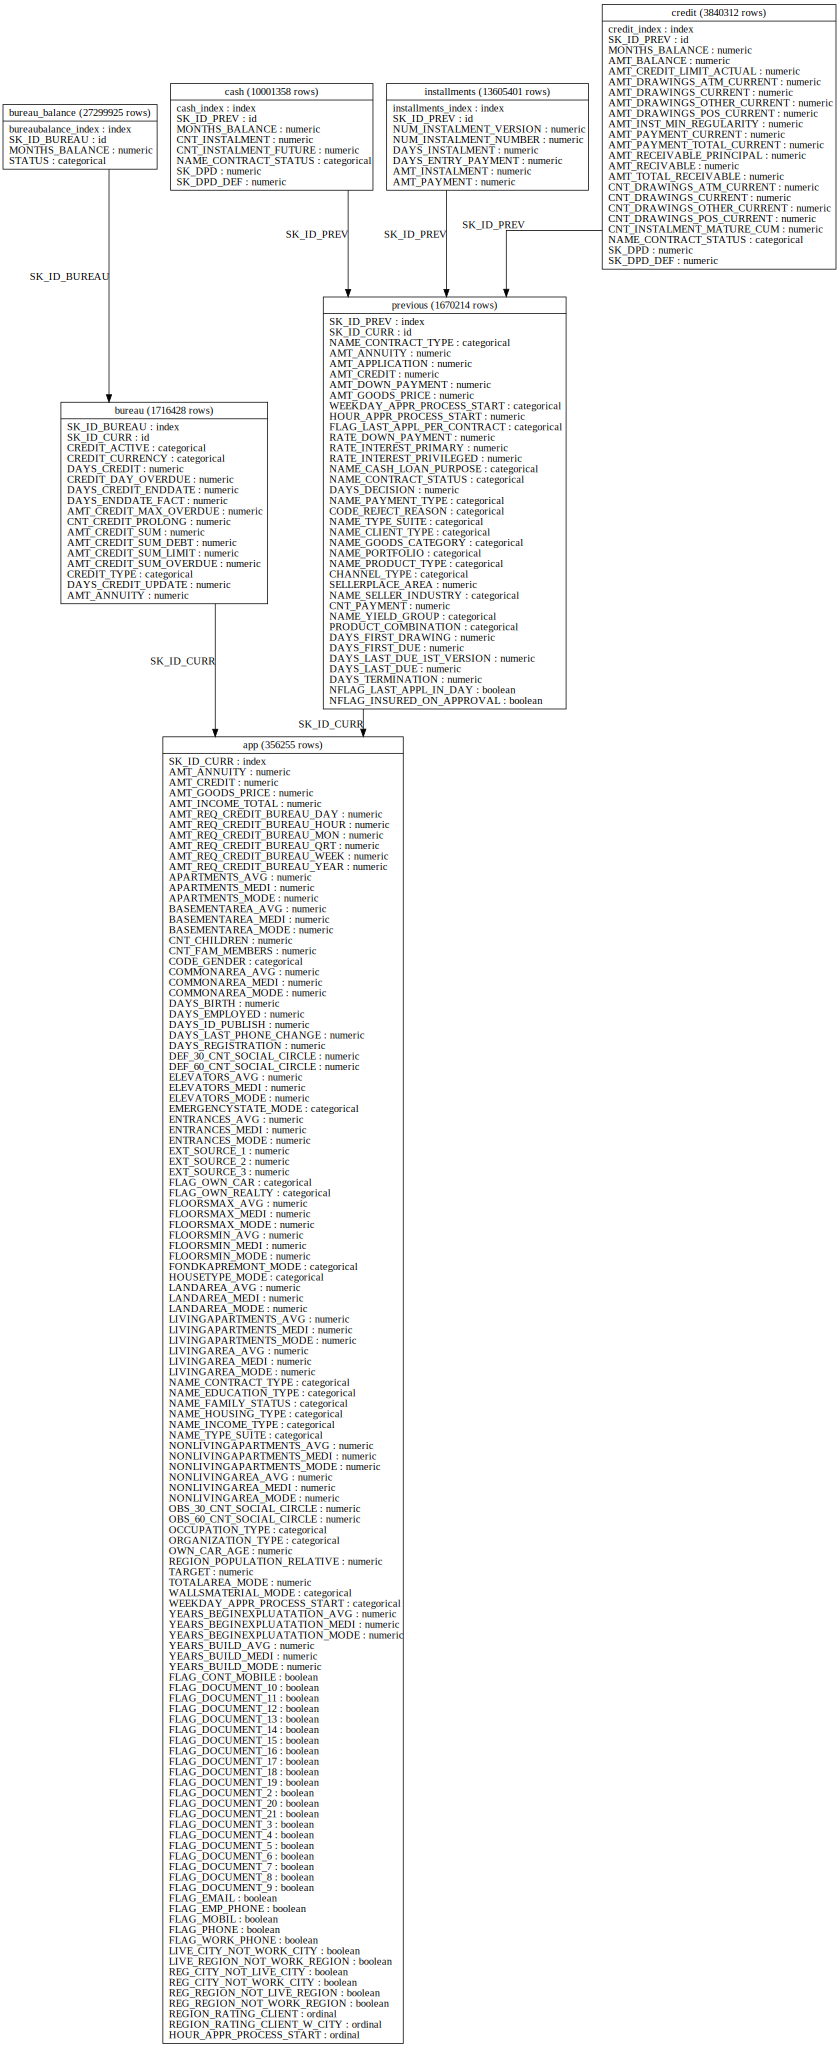

In [20]:
es.plot()

# Feature Primitives
# 特征基元

A [feature primitive](https://docs.featuretools.com/automated_feature_engineering/primitives.html) is an operation applied to a table or a set of tables to create a feature. These represent simple calculations, many of which we already use in manual feature engineering, that can be stacked on top of each other to create complex deep features. Feature primitives fall into two categories:
<br>特征基元是应用于表或一组表集来构建特征的操作准则.这些简单的计算方法, 我们在人工构造变量过程中已经使用了很多,可以彼此堆叠以创建复杂的深层特征.特征基元分为两类:  

* __Aggregation__: function that groups together children for each parent and calculates a statistic such as mean, min, max, or standard deviation across the children. An example is the maximum previous loan amount for each client. An aggregation covers multiple tables using relationships between tables.
* __聚合__: 该函数将每个父的子分组在一起进行统计数据, 例如平均值,最小值,最大值或标准差,以及子之间的交叉. 一个示例是每个客户的最大历史贷款金额, 使用表之间的关系多个表进行聚合.
* __Transformation__: an operation applied to one or more columns in a single table. An example would be taking the absolute value of a column, or finding the difference between two columns in one table.
* __转换__: 该操作应用于单表中一个或多个列. 例如取一列的绝对值,或查找一张表中两列的差值.


A list of the available features primitives in featuretools can be viewed below.
<br>Featuretools可以使用的特征基元如下表.

In [21]:
# List the primitives in a dataframe
# 特征基元表.
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100

primitives[primitives['type'] == 'aggregation'].tail(10)

,name,type,description
12,last,aggregation,Determines the last value in a list.
13,mode,aggregation,Determines the most commonly repeated value.
14,sum,aggregation,"Calculates the total addition, ignoring `NaN`."
15,std,aggregation,"Computes the dispersion relative to the mean value, ignoring `NaN`."
16,median,aggregation,Determines the middlemost number in a list of values.
17,avg_time_between,aggregation,Computes the average number of seconds between consecutive events.
18,trend,aggregation,Calculates the trend of a variable over time.
19,percent_true,aggregation,Determines the percent of `True` values.
20,time_since_last,aggregation,Calculates the time elapsed since the last datetime (default in seconds).
21,num_unique,aggregation,"Determines the number of distinct values, ignoring `NaN` values."


In [22]:
primitives[primitives['type'] == 'transform'].tail(10)

,name,type,description
68,less_than_equal_to_scalar,transform,Determines if values are less than or equal to a given scalar.
69,isin,transform,Determines whether a value is present in a provided list.
70,cum_mean,transform,Calculates the cumulative mean.
71,add_numeric_scalar,transform,Add a scalar to each value in the list.
72,less_than,transform,Determines if values in one list are less than another list.
73,num_words,transform,Determines the number of words in a string by counting the spaces.
74,absolute,transform,Computes the absolute value of a number.
75,cum_sum,transform,Calculates the cumulative sum.
76,multiply_boolean,transform,Element-wise multiplication of two lists of boolean values.
77,not_equal_scalar,transform,Determines if values in a list are not equal to a given scalar.


In [23]:
primitives.type.unique()

array(['aggregation', 'transform'], dtype=object)

# Deep Feature Synthesis
# 深度特征合成

[Deep Feature Synthesis (DFS)](https://www.featurelabs.com/blog/deep-feature-synthesis/) is the method Featuretools uses to make new features. DFS stacks feature primitives to form features with a "depth" equal to the number of primitives. For example, if we take the maximum value of a client's previous loans (say `MAX(previous.loan_amount)`), that is a "deep feature" with a depth of 1. To create a feature with a depth of two, we could stack primitives by taking the maximum value of a client's average monthly payments per previous loan (such as `MAX(previous(MEAN(installments.payment)))`). In manual feature engineering, this would require two separate groupings and aggregations and took more than 15 minutes to write the code per feature. 
<br> [深度特征合成 (DFS)]是featuretools用于创建新特征的方法.DFS基于特征基元堆栈特征"深度"等同于特征数.例如, 我们要计算客户历史借款最大值(称`MAX(previous.loan_amount)`),这是一个深度为1的深度特征.创建一个深度为2的特征. 我们需要堆叠特征客户的每笔贷款平均月还款额的最大值(例如`MAX(previous(MEAN(installments.payment)))`).在手动特征工程中, 需要两次单独分组和聚合花费超过15分钟为每一个特征写代码.   

Deep Feature Synthesis is an extremely powerful method that allows us to overcome our human limitations on time and creativity by building features that we would never be able to think of on our own (or would not have the patience to implement). Furthermore, DFS is applicable to any dataset with only very minor changes in syntax. In feature engineering, we generally apply the same functions to multiple datasets, but when we do it by hand, we have to re-write the code because it is problem-specific. Featuretools code can be applied to any dataset because it is written at a higher level of abstraction.
<br>深度特征合成是一个非常有效的方法,在创造特征过程中为我们人类克服了时间局限性和想象力.无需独立自主进行思考(不用耐心去实现特征构建).因此,DFS只需要进行细微调整即可应用于任何数据集. 在特征工程中, 我们通常应用相同函数于不同的数据集, 但是当我们手动完成时, 必须重复编写代码, 因为每个项目是特定的. Featuretools代码可以应用于任何数据集因为他是更高级的抽象.

The [original paper on automated feature engineering using Deep Feature Synthesis](https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf) is worth a read if you want to understand the concepts at a deeper level.
你可以阅读[使用深度特征合成在自动化特征工程的论文]如果你想更深层次理解的话.

To perform DFS in featuretools, we use the `dfs`  function passing it an `entityset`, the `target_entity` (where we want to make the features), the `agg_primitives` to use, the `trans_primitives` to use, the `max_depth` of the features, and a number of other arguments depending on our use case. There are also options for multi-processing with `njobs` and the information that is printed out with `verbose`.
<br>为了在Featuretools中执行DFS, 我们通过使用`dfs`函数的`entityset`,`target_entity`(我们需要制作的特征), `agg_primitives`,`trans_primitives`,`max_depth`等参数,以及其他一些参数,具体取决于我们的用例. 还有多任务参数`njobs`和信息打印参数`verbose`.  

One other important argument is __`features_only`__. If we set this to `True`, `dfs` will only make the feature names and not calculate the actual values of the features (called the feature matrix). This is useful when we want to inspect the feature that will be created and we can also save the features to use with a different dataset (for example when we have training and testing data).
<br>另一个重要参数是`eatures_only`. 如果我们设置为`True`, `dfs`将只生成特征名,而不会实际计算出特征值(特征矩阵值). 当我们进行特征创建和保存检查时,只生成特征名而不进行计算是非常有用的.

## Deep Feature Synthesis with Default Primitives
## 深度特征合默认原函数

Without using any domain knowledge we can make thousands of features by using the default primitives in featuretools. This first call will use the default aggregation and transformation primitives,  a max depth of 2, and calculate primitives for the `app` entity. We will only generate the features themselves (the names and not the values) which we can save and inspect.
<br>在Featuretools中不使用任何领域知识我们可以使用深度特征合成默认原函数构建成千上万特征.首先使用聚合和转换原函数. 一个深度为2的实体特征. 将只生成特征名进行保存和检查.

In [24]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"]

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_entity = 'app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       where_primitives = [], seed_features = [],
                       max_depth = 2, n_jobs = -1, verbose = 1,
                       features_only=True)

Built 2069 features


Even a basic call to deep feature synthesis gives us over 1500 features to work with. Granted, not all of these will be important, but this still represents hundreds of hours that we saved. Moreover, `dfs` might be able to find important features that we would never have thought of in the first place.
<br> 即使是对深度特征合成基本调用也能为我们生成1500多个特征. 诚然,这些特征并非都重要. 但是依旧意味着我们可以节约数百小时.此外,`dfs`也许能找到重要的特征, 在这之前我们从未想到过的特征.   

We can look at the some of the feature names:
<br>我们可以查看一些特征名称:

In [25]:
feature_names[-15:]

[<Feature: MODE(credit.previous.NAME_CONTRACT_TYPE)>,
 <Feature: MODE(credit.previous.SK_ID_CURR)>,
 <Feature: MODE(credit.previous.NAME_PRODUCT_TYPE)>,
 <Feature: MODE(credit.previous.NAME_YIELD_GROUP)>,
 <Feature: MODE(credit.previous.PRODUCT_COMBINATION)>,
 <Feature: MODE(credit.previous.NAME_CASH_LOAN_PURPOSE)>,
 <Feature: MODE(credit.previous.NAME_CLIENT_TYPE)>,
 <Feature: MODE(credit.previous.NAME_TYPE_SUITE)>,
 <Feature: MODE(credit.previous.CHANNEL_TYPE)>,
 <Feature: MODE(credit.previous.NAME_GOODS_CATEGORY)>,
 <Feature: MODE(credit.previous.NAME_PORTFOLIO)>,
 <Feature: MODE(credit.previous.NAME_CONTRACT_STATUS)>,
 <Feature: MODE(credit.previous.FLAG_LAST_APPL_PER_CONTRACT)>,
 <Feature: MODE(credit.previous.WEEKDAY_APPR_PROCESS_START)>,
 <Feature: MODE(credit.previous.NAME_SELLER_INDUSTRY)>]

Notice how featuretools stacks multiple primitives on top of each other. This one of the ideas behind Deep Feature Synthesis and automated feature engineering. Rather than having to do these groupings and aggregations by ourselves, Featuretools is able to handle it all using the framework (`entities`, `relationships`, and `primitives`) that we provide. We can also use Featuretools to expand on our domain knowledge. 
<br> 注意Featuretools是如何将多个基元进行批次堆叠.这是深度特征合成和自动特征工程的背后思路之一,不必人工进行分组和聚合. Featuretools可以使用架构(`实体`,`关系`,和`基元`)进行, 我们也可以使用Featuretools扩展我们的领域知识. 

# Building on Top of Domain Features
# 建立在领域知识上的特征

Featuretools will automatically build thousands of features for us, but that does not mean we can't use our own knowledge to improve the predictive performance. Featuretools is able to augment our domain knowledge by stacking additional features on top of our domain knowledge based features. We identified and created numerous useful features in the manual feature engineering notebook, based on our own knowledge and that of thousands of data scientists working on this problem on Kaggle. Rather than getting only one domain knowledge feature, we can effectively get dozens or even hundreds. __Here we'll explain the options for using domain knowledge, but we'll stick with the simple implementation of Featuretools for comparison purposes.__

<br> Featuretools可以自动为我们构建成千上万个特征. 但是并不意味着我们不能使用领域知识去提升预测性能. Featuretools可以添加我们的领域知识通过堆放额外的基础领域特征.我们根据自己的知识以及数千位在Kaggle上解决此问题的数据科学家的知识,在手动特征工程笔记本中识别并创建了许多有用的特征.我们不仅可以获得一个领域知识特征,而且可以有效获得数十甚至数百个知识特征.__在这里,我们将说明使用领域知识的选项是为了比较.但我们将坚持使用Featuretools的简单实现.__
For more information on any of these topics, see the [documentation](https://docs.featuretools.com/guides/tuning_dfs.html) or the other notebooks in this repository. 
<br> 更多信息见Featuretools[文档](https://docs.featuretools.com/guides/tuning_dfs.html)或者阅读其他文章.
### Seed Features 
### 种子特征
Seed features are domain features that we make in the data that Featuretools is then able to build on top of. For example, we saw that the rate of a loan is an important feature because a higher rate loan is likely more risky. In Featuretools, we can encode the loan rate (both for the current loan and for previous loans) as a seed feature and Featuretools will build additional explanatory variables on this domain knowledge wherever possible. 
<br> 种子特征是我们在数据中创建的领域特征, 然后可以在Featuretools的基础上构建它们. 例如, 我们看到贷款利率是一个重要特征, 因为利率较高的贷款可能更具风险. 在Featuretools中, 我们可以将贷款利率(当前贷款和历史贷款两者)编码为种子特征, Featuretools会在可能的情况下基于此领域知识构建其他解释变量.

### Interesting Values
### 有趣值
Interesting values have a similar idea to seed features except they allow us to make conditional features. For example, we might want to find for each client the mean amount of previous loans that have been closed and the mean amount of previous loans that are still active. By specifying interesting values in `bureau` on the `CREDIT_ACTIVE` variable we can have Featuretools do exactly that! Carrying this out by hand would be extremely tedious and present numerous opportunities for errors.
<br> 有趣值与种子特征具有相似的思路, 除了它们使我们能够形成条件特征. 例如, 我们可能想为每个客户查找已关闭的历史贷款的平均金额和仍处于还款状态的历史贷款的平均金额. 通过在表`bureau`中变量`CREDIT_ACTIVE`指定有趣的值, 我们可以让Featuretools做到这一点, 手工执行此操作将非常繁琐,并且积极可能发生错误.

### Custom Primitives
### 自定义基元

If we aren't satisfied with the primitives available to use in Featuretools, we can write our own functions to transform or aggregate the data. This is one of the most powerful capabilities in featuretools because it allows us to make very specific operations that can then be applied to multiple datasets.
<br>如果我们不满意Featuretools中可用的基元, 可以自定义函数完成数据聚合和转换. 这是Featuretools最有用之处, 因为他可以为编写很多特征操作应用于多个数据集.

__In this notebook we concentrate on a basic implementation of Featuretools, but keep in mind these capabilities are available for optimizing the library and using domain knowledge!__
<br>__在本文中将专注于Featuretools的基本应用, 但是请注意一些功能可以用于优化数据和使用领域知识!__

# Selecting Primitives
# 基元选择

For our actual set of features, we will use a select group of primitives rather than just the defaults. This will generate over 1800 features to use for modeling.
<br> 在实践特征构建中, 我们使用一组基元并进行定义基元组, 他们将生成1800多个特征.

In [26]:
# Specify primitives
agg_primitives =  ["sum", "max", "min", "mean", "count", "percent_true", "num_unique", "mode"]
trans_primitives = ['percentile', 'and']

In [27]:
# Deep feature synthesis 
feature_names = ft.dfs(entityset=es, target_entity='app',
                       agg_primitives = agg_primitives,
                       trans_primitives = trans_primitives,
                       n_jobs = -1, verbose = 1,
                       features_only = True,
                       max_depth = 2)

Built 2188 features


In [28]:
ft.save_features(feature_names, 'input/features.txt')

If we save the features, we can then use them with `calculate_feature_matrix`. This is useful when we want to apply the same features across datasets (such as if we have separate trainig/testing).
如果我们保存特征, 我们可以使用他们进行`特征矩阵计算`. 这非常有用, 当我们想要在不同数据集生成相同特征时(例如我们有特定的训练和测试集).

## Run Full Deep Feature Synthesis
## 运行深度特征合成

If we are content with the features that will be built, we can run deep feature synthesis and create the feature matrix. The following call runs the full deep feature synthesis. This might take a long time depending on your machine. Featuretools does allow for parallel processing, but each core must be able to handle the entire entityset.
<br>如果我们对将要构建的特征满意, 则可以运行深度特征合成并创建特征矩阵. 以下调用运行完整的深度特征合成. 根据您的计算机,这可能需要很长时间. Featuretools确实允许并行处理, 但是每个核必须能够处理整个实体集.

__An actual run of this code was completed using Dask which can be seen in the [Featuretools on Dask notebook](https://github.com/Featuretools/Automated-Manual-Comparison/blob/master/Loan%20Repayment/notebooks/Featuretools%20on%20Dask.ipynb).__ The Dask code takes under 2 hours to run and is a great example of how we can use parallel processing to use our resouces in the most efficient manner.
__该代码运行实际上市使用Dask(云服务器)完成的.Dask上代码运行时间不到2个小时, 这是一个很好的示例, 说明了我们如何使用并行处理以最有效的方式使用资源.__

In [29]:
import sys
print('Total size of entityset: {:.5f} gb.'.format(sys.getsizeof(es) / 1e9))

Total size of entityset: 11.80507 gb.


In [30]:
import psutil

print('Total number of cpus detected: {}.'.format(psutil.cpu_count()))
print('Total size of system memory: {:.5f} gb.'.format(psutil.virtual_memory().total / 1e9))

Total number of cpus detected: 12.
Total size of system memory: 17.17987 gb.


In [ ]:
# feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='app',
#                                        agg_primitives = agg_primitives,
#                                        trans_primitives = trans_primitives,
#                                        n_jobs = -1, verbose = 1, features_only = False,
#                                        max_depth = 1, chunk_size = 10)

In [ ]:
feature_matrix.reset_index(inplace = True)
feature_matrix.to_csv('input/feature_matrix.csv', index = False)

To download the feature matrix, head to https://www.kaggle.com/willkoehrsen/home-credit-default-risk-feature-tools and select the `feature_matrix_article.csv`. There are several other versions of automatically engineered feature matrices available there as well. 
<br> 在这个[地址](https://www.kaggle.com/willkoehrsen/home-credit-default-risk-feature-tools)选择`feature_matrix_article.csv`下载特征矩阵.那里还有自动特征工程特征矩阵的其他几种版本.

# Conclusions
# 结论

In this notebook, we saw how to implement automated feature engineering for a data science problem. __Automated feature engineering allows us to create thousands of new features from a set of related data tables, significantly increasing our efficiency as data scientists.__ Moreover, we can still use domain knowledge in our features and even augment our domain knowledge by building on top of our own hand-built features. The main takeaways are:
<br>在本文, 我们看到了如何针对数据科学问题实施自动化特征工程. __自动化特征工程为我们创建数千个特征基于一个关系表,大大提高了我们作为数据科学家的效率.__ 此外, 我们依然可以使用领域知识,甚至可以通过手动构建特征主题来加强领域知识.主要收获:
* Automated feature engineering took 1 hour to implement compared to 10 hours for manual feature engineering
* 自动化特征工程消耗1小时执行完10小时的人工特征工程.
* Automated feature engineering built thousands of features in a few lines of code compared to dozens of lines of code per feature for manual engineering.
* 自动化特征工程只需要少了代码(相比于人工特征工程每个特征都要编写大量逻辑代码)即可构建数千个特征.  
* Overall, performance of the automated features are comparable or better than those of the manual features (see the Results notebook)
* 总体上, 自动化特征工程性能比人工特征工程性能好(见另一个笔记).

The benefits of automated feature engineering are significant and will considerably help us in our role as data scientists. It won't alleviate the need for data scientists, but rather will make us more efficient and build better predictive pipelines in less time.
<br>自动化特征工程的好处是显著的,将极大地帮助我们作为一名数据科学家, 它不会减少对数据科学家的需求, 而是可以使我们更高效, 并在更短的时间内建立更好的预测管道.